In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Read datasets**

In [2]:
import pandas as pd
train_transaction = pd.read_csv("input/clean_train.csv")

**Split train data in train and "test" - standardize data**

In [4]:
x_raw = train_transaction.drop('isFraud', axis = 1 )
y = train_transaction.isFraud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
x = sscaler.fit_transform(x_raw)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=230)

x_train_pca = pca.fit_transform(x_train)

In [7]:
x_test_pca = pca.transform(x_test)

**Use RandomForrestClassifier for modelling -- ! TO USE fit not fit_transform!**

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

In [10]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(x_train_pca, y_train)

# predict on test set
rfc_pred = rfc.predict(x_test_pca)
y_rfc  = rfc.predict_proba(x_test_pca)

acc_s_rfc = accuracy_score(y_test, rfc_pred)
print ("Accuracy score decision tree classifier: ", acc_s_rfc)
curve_rfc   = roc_curve(y_test, y_rfc[:, 1])
auc_rfc   = auc(curve_rfc[0], curve_rfc[1])

Accuracy score decision tree classifier:  0.9748648129960149


**Use GradientBoostingClassifier for modeling**

In [14]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.03)

cbc.fit(x_train_pca,y_train,eval_set=(x_test_pca, y_test),verbose=100);     

0:	learn: 0.6452351	test: 0.6452018	best: 0.6452018 (0)	total: 235ms	remaining: 3m 54s
100:	learn: 0.1127649	test: 0.1124876	best: 0.1124876 (100)	total: 19s	remaining: 2m 49s
200:	learn: 0.1067026	test: 0.1072280	best: 0.1072280 (200)	total: 39.3s	remaining: 2m 36s
300:	learn: 0.1032868	test: 0.1044791	best: 0.1044791 (300)	total: 59.1s	remaining: 2m 17s
400:	learn: 0.1006368	test: 0.1024624	best: 0.1024624 (400)	total: 1m 18s	remaining: 1m 57s
500:	learn: 0.0982203	test: 0.1007274	best: 0.1007274 (500)	total: 1m 38s	remaining: 1m 38s
600:	learn: 0.0960540	test: 0.0992370	best: 0.0992370 (600)	total: 1m 59s	remaining: 1m 19s
700:	learn: 0.0941512	test: 0.0980308	best: 0.0980308 (700)	total: 2m 19s	remaining: 59.5s
800:	learn: 0.0923668	test: 0.0968521	best: 0.0968521 (800)	total: 2m 47s	remaining: 41.5s
900:	learn: 0.0907778	test: 0.0959060	best: 0.0959060 (900)	total: 3m 16s	remaining: 21.5s
999:	learn: 0.0893496	test: 0.0950676	best: 0.0950676 (999)	total: 3m 47s	remaining: 0us

bes

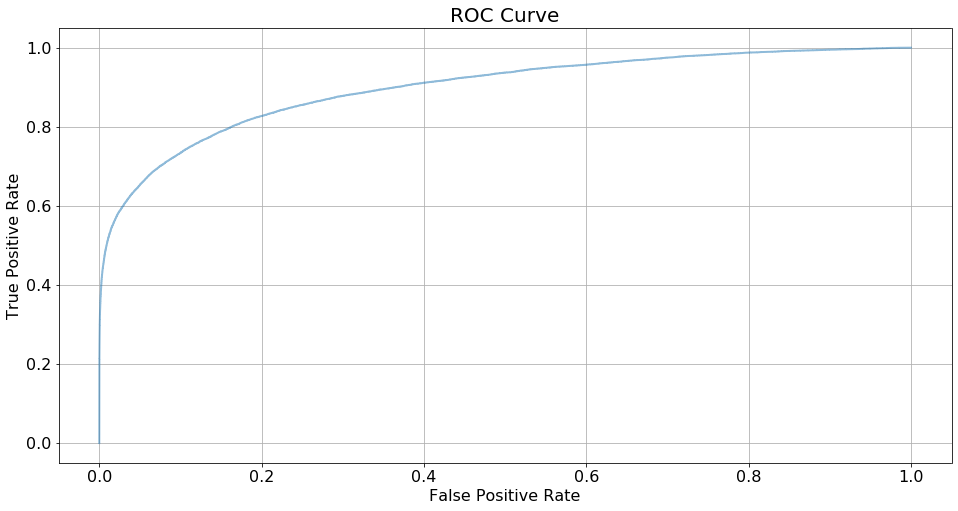

In [16]:
from catboost.utils import get_roc_curve
from catboost import Pool

catboost_pool = Pool(x_train_pca, y_train)
(fpr, tpr, thresholds) = get_roc_curve(cbc, catboost_pool, plot=True)


In [17]:
# predict on test set
cbc_pred = cbc.predict(x_test_pca)
y_cbc  = cbc.predict_proba(x_test_pca)

acc_s_cbc = accuracy_score(y_test, cbc_pred)
print ("Accuracy score cat boost classifier: ", acc_s_cbc)
curve_cbc   = roc_curve(y_test, y_cbc[:, 1])
auc_cbc   = auc(curve_cbc[0], curve_cbc[1])

Accuracy score cat boost classifier:  0.9740632867093395


**Draw ROC**

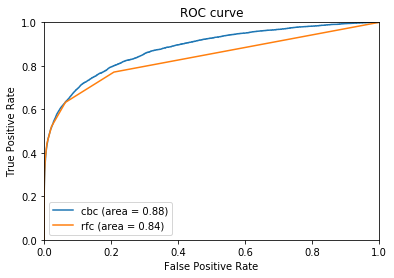

In [18]:
import matplotlib.pyplot as plt

plt.plot(curve_cbc[0], curve_cbc[1], label='cbc (area = %0.2f)' % auc_cbc)
plt.plot(curve_rfc[0], curve_rfc[1], label='rfc (area = %0.2f)' % auc_rfc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();

In [19]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision_cbc = average_precision_score(y_test, y_cbc[:,1])
average_precision_rfc = average_precision_score(y_test, y_rfc[:,1])

print('Average precision-recall score CBC: {}'.format(average_precision_cbc))
print('Average precision-recall score RFC: {}'.format(average_precision_rfc))

Average precision-recall score CBC: 0.5231384174653396
Average precision-recall score RFC: 0.477978657623666


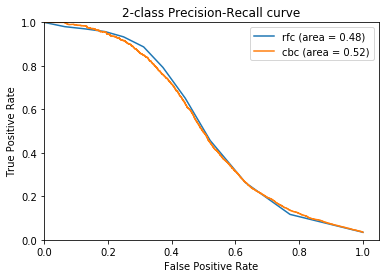

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision_cbc, recall_cbc, _ = precision_recall_curve(y_test, y_cbc[:,1])
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_rfc[:,1])

#plt.step(recall_rfc, precision_rfc, color='b', alpha=0.2, where='post')
#plt.step(recall_gbc, precision_gbc, color='c', alpha=0.2, where='post')
#plt.fill_between(recall_rfc, precision_rfc, step='post', alpha=0.2, color='b')
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

plt.plot(recall_rfc, precision_rfc, label='rfc (area = %0.2f)' % average_precision_rfc)
plt.plot(recall_cbc, precision_cbc, label='cbc (area = %0.2f)' % average_precision_cbc)

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('2-class Precision-Recall curve');

plt.legend();